In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_explainer import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *

sys.path.append("../..")

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    DISCHARGE_DISPOSITION,
    READMISSION,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    LENGTH_OF_STAY_IN_ER,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
)
from cyclops.processors.constants import EMPTY_STRING
from cyclops.processors.admin import AdminProcessor
from cyclops.processors.vitals import VitalsProcessor
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.outcomes import OutcomesProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.orm import Database

%reload_ext autoreload
%reload_ext nb_black

2022-04-20 13:42:28.407065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-04-20 13:42:28.407121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-20 13:42:31.560597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 13:42:31.561943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0

<IPython.core.display.Javascript object>

# Parameters #

In [52]:
PATH = "/mnt/nfs/project/delirium/drift_exp/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
PATH = "/mnt/nfs/project/delirium/drift_exp/"
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
calc_acc = True
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
SHIFTS = ["pre-covid", "covid", "summer", "winter", "seasonal"]
OUTCOMES = ["length_of_stay_in_er", "mortality_in_hospital"]
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW"]
DR_TECHNIQUES = ["NoRed", "SRP", "PCA", "BBSDs_FFNN"]
MD_TESTS = ["MMD", "LK", "LSDD"]

<IPython.core.display.Javascript object>

# Load Data #

In [53]:
SHIFT_EXPERIMENT = input("Select experiment: ")
OUTCOME = input("Select outcome variable: ")
if SHIFT_EXPERIMENT != "hosp_type":
    HOSPITAL = [input("Select hospital: ")]
NA_CUTOFF = 0.60

if SHIFT_EXPERIMENT == "covid":
    SHIFT_BS = ["pre-covid", "covid"]

if SHIFT_EXPERIMENT == "seasonal":
    SHIFT_BS = ["summer", "winter", "seasonal"]
    
(
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    feats,
    orig_dims,
) = import_dataset_hospital(
    SHIFT_EXPERIMENT, OUTCOME, HOSPITAL, NA_CUTOFF, shuffle=True
)


Select experiment: seasonal
Select outcome variable: length_of_stay_in_er
Select hospital: UHNTG


2022-04-21 10:40:57,833 INFO cyclops.processors.base - Processing raw admin data...
2022-04-21 10:40:57,840 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-21 10:40:57,851 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-21 10:41:50,445 INFO cyclops.utils.profile - Finished executing function process in 52.611823 s


<IPython.core.display.Javascript object>

# Drift Tests #

Select Pre-Processing: NoRed
Select Two-Sample Testing: LSDD


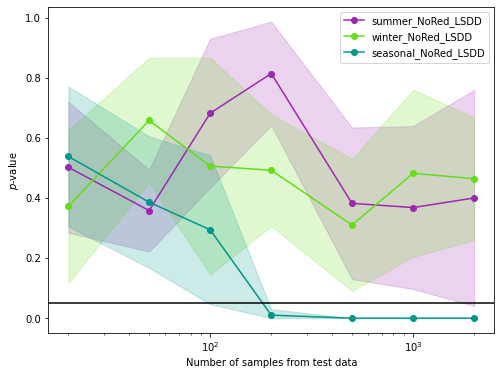

<IPython.core.display.Javascript object>

In [54]:
# Run shift experiments
if os.path.exists(PATH + "/mean_dr_md.pkl"):
    with open(PATH + "/mean_dr_md.pkl", "rb") as f:
        mean_dr_md = pickle.load(f)
else:
    mean_dr_md = np.ones(
        (len(SHIFTS), len(HOSPITALS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(PATH + "/std_dr_md.pkl"):
    with open(PATH + "/std_dr_md.pkl", "rb") as f:
        std_dr_md = pickle.load(f)
else:
    std_dr_md = np.ones(
        (len(SHIFTS), len(HOSPITALS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

for si, SHIFT in enumerate(SHIFTS):
    for hi, HOSPITAL in enumerate(HOSPITALS):
        for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
            for mi, MD_TEST in enumerate(MD_TESTS):
                if np.any(mean_dr_md[si, hi, di, mi, :] == -1):
                    print(
                        "{} | {} | {} | {}".format(
                            SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                        )
                    )
                    try:
                        mean_p_vals, std_p_vals = run_shift_experiment(
                            SHIFT,
                            OUTCOME,
                            [HOSPITAL],
                            PATH,
                            DR_TECHNIQUE,
                            MD_TEST,
                            SAMPLES,
                            DATASET,
                            SIGN_LEVEL,
                            NA_CUTOFF,
                            RANDOM_RUNS,
                            calc_acc=True,
                        )
                        mean_dr_md[si, hi, di, mi, :] = mean_p_vals
                        std_dr_md[si, hi, di, mi, :] = std_p_vals
                    except ValueError as e:
                        print("Value Error")
                        pass

DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(SHIFTS):
    for hi, hospital in enumerate(HOSPITALS):
        for di, dr_technique in enumerate(DR_TECHNIQUES):
            for mi, md_test in enumerate(MD_TESTS):
                if (
                    shift in SHIFT_BS
                    and hospital == HOSPITAL
                    and dr_technique == DIM_RED
                    and md_test == MD_TEST
                ):
                    errorfill(
                        np.array(SAMPLES[1:]),
                        mean_dr_md[si, hi, di, mi, 1:],
                        std_dr_md[si, hi, di, mi, 1:],
                        fmt=linestyles[di] + markers[di],
                        color=colorscale(colors[si], brightness[mi]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                    )
plt.xlabel("Number of samples from test data")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(PATH + "/mean_dr_md.pkl"):
    with open(PATH + "/mean_dr_md.pkl", "wb") as f:
        pickle.dump(mean_dr_md, f)
if not os.path.exists(PATH + "/std_dr_md.pkl"):
    with open(PATH + "/std_dr_md.pkl", "wb") as f:
        pickle.dump(std_dr_md, f)

# Build Model #

In [70]:
(
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    feats,
    orig_dims,
) = import_dataset_hospital(
    SHIFT_EXPERIMENT, OUTCOME, [HOSPITAL], NA_CUTOFF, shuffle=True
)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT_EXPERIMENT, OUTCOME, HOSPITAL, MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_train, y_train, X_val, y_val)

2022-04-21 11:05:12,754 INFO cyclops.processors.base - Processing raw admin data...
2022-04-21 11:05:12,761 INFO cyclops.processors.base - # samples: 85953, # encounters: 85953
2022-04-21 11:05:12,769 INFO cyclops.processors.admin - # admin features: 2, # encounters: 85953
2022-04-21 11:05:58,536 INFO cyclops.utils.profile - Finished executing function process in 45.782064 s


Select Model: xgb


<IPython.core.display.Javascript object>

### Performance on Source Data ###

<AxesSubplot:title={'center':'Average Precision: 0.978074'}, xlabel='Recall', ylabel='Precision'>

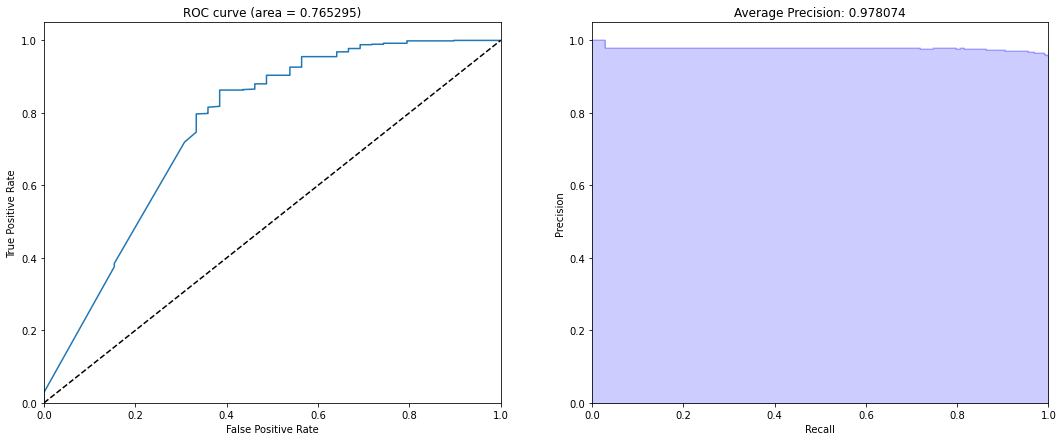

<IPython.core.display.Javascript object>

In [71]:
y_pred_prob = optimised_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'Average Precision: 0.953797'}, xlabel='Recall', ylabel='Precision'>

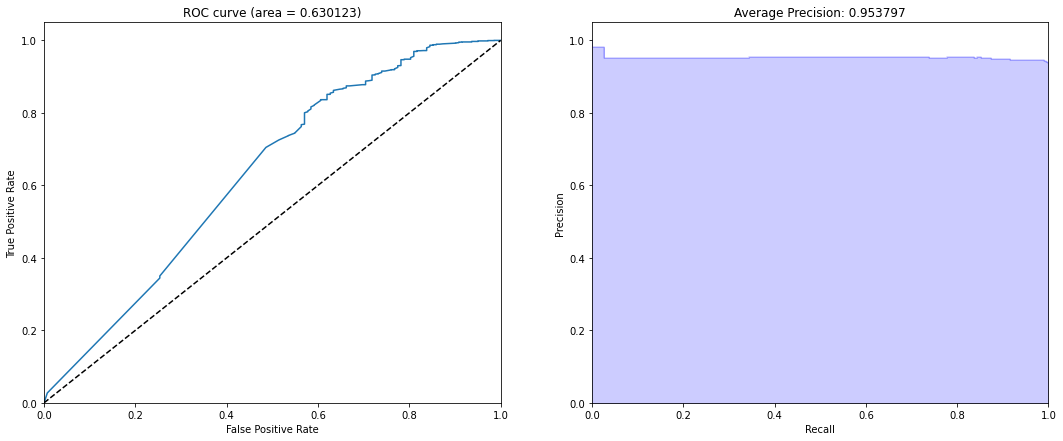

<IPython.core.display.Javascript object>

In [72]:
y_pred_prob = optimised_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

## Performance by Sample Size ##

In [73]:
def __unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

<IPython.core.display.Javascript object>

In [74]:
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val, y_val = __unison_shuffled_copies(X_val, y_val)
        X_test, y_test = __unison_shuffled_copies(X_test, y_test)

        y_val_pred_prob = optimised_model.predict_proba(X_val[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val[:sample], y_val_pred_prob, pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val[:sample], y_val_pred_prob)

        y_test_pred_prob = optimised_model.predict_proba(X_test[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test[:sample], y_test_pred_prob, pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test[:sample], y_test_pred_prob)

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless
No negative 

<IPython.core.display.Javascript object>

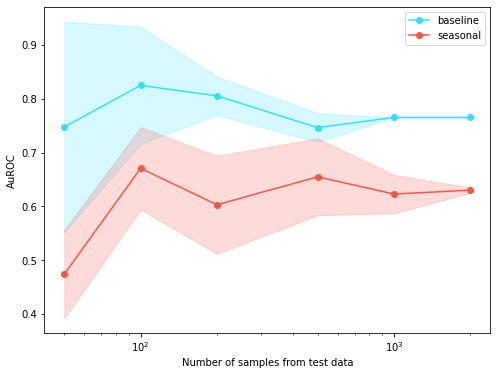

<IPython.core.display.Javascript object>

In [75]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


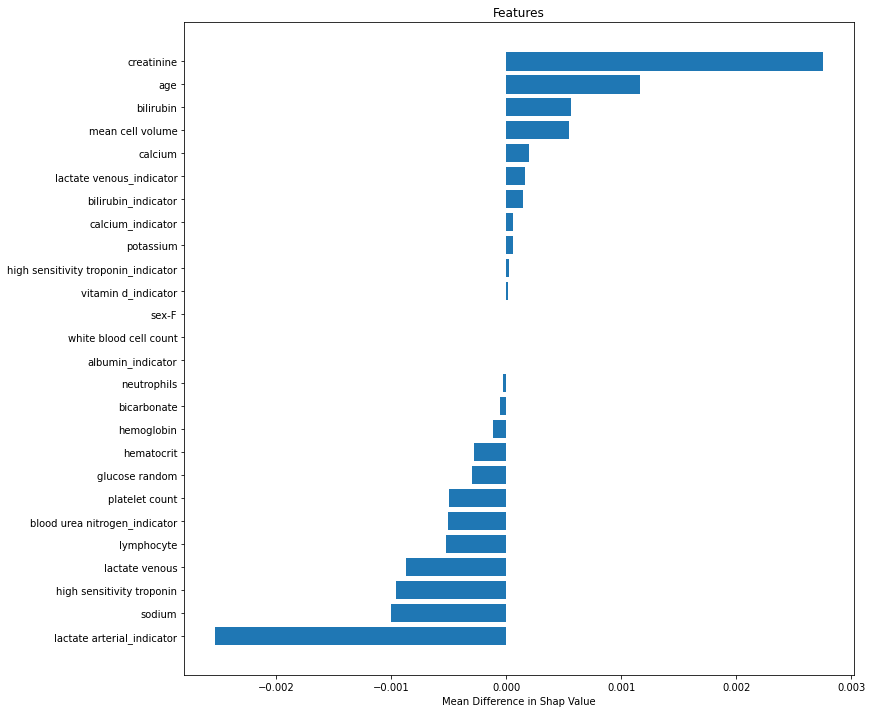

<IPython.core.display.Javascript object>

In [76]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val, columns=feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_test, columns=feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if x != 0))
)
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()